# Imort Libraries

In [26]:
import datetime
import logging
import time
import azure.functions as func
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from datetime import date, timedelta
from shared_code import utils

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Initialize Storage Account

In [2]:
azure_utils = utils.AzureUtils()
secret_client = azure_utils.initialize_key_vault()

sa_secret = azure_utils.get_key_vault_secret(secret_client, 'sa-booli')
sa_name = azure_utils.get_key_vault_secret(secret_client, 'sa-name')
storage_account = azure_utils.initialize_storage_account_ad(sa_secret.value, sa_name.value)

# Scraping & Storing Data

In [11]:
object_type = "Lägenhet"
minSoldDate = "2022-01-01"
maxSoldDate = "2022-01-02"
rooms = ""
hasBalcony = ""
hasFireplace = ""
hasElevator = ""
area_id = 143

booli_utils = utils.Booli()

data = booli_utils.run_query_sold(object_type, minSoldDate, maxSoldDate, rooms, hasBalcony, hasFireplace, hasElevator, area_id, 1)
total_number_of_pages = data["data"]["search"]["pages"]
total_number_of_objects = data["data"]["search"]["totalCount"]
print(f"Total number of pages: {total_number_of_pages}")

res = []
for page in range(1, total_number_of_pages + 1):
    print(f'Scraping page: {page} / {total_number_of_pages}')
    data = booli_utils.run_query_sold(object_type, minSoldDate, maxSoldDate, rooms, hasBalcony, hasFireplace, hasElevator, area_id, page)
    
    for object in data["data"]["search"]["result"]:
        res.append(object)
    
    print(f"Total number of objects stored {len(res)} / {total_number_of_objects}")
    print("")
    print("--------------------------------------------")
    print("")
    
df = pd.json_normalize(res)

azure_utils.upload_csv_to_datalake(df, "raw/sold/all", f"Sold_{object_type}_{rooms}_{area_id}_{minSoldDate}_{maxSoldDate}.csv")

Total number of pages: 1
Scraping page: 1 / 1
Total number of objects stored 1 / 1

--------------------------------------------



In [204]:
# !pip install -q pyscbwrapper
from pyscbwrapper import SCB

In [211]:
scb = SCB("en")

In [212]:
scb.info()
scb.go_down("FM", "FM5001")
scb.info()

[{'id': 'FM5001A', 'type': 'l', 'text': 'Financial Market Statistics'},
 {'id': 'FM5001B',
  'type': 'l',
  'text': 'Claims and liabilities outside Sweden'},
 {'id': 'FM5001C', 'type': 'l', 'text': 'Deposit and lending rates'},
 {'id': 'FM5001S', 'type': 'l', 'text': 'Economic indicators'},
 {'id': 'FM5001X', 'type': 'l', 'text': 'Key figures'}]

In [193]:
scb.go_down("PR", "PR0101", "PR0101G", "KPIF")
# scb.go_up()
# scb.info()
# scb.get_variables()

observations = ['CPIF, Index, 1987=100', 'CPIF, monthly changes, 1987=100', 'CPIF, annual changes, 1987=100']
scb.set_query(observations = observations)
#print(scb.get_query())
data = scb.get_data()["data"]

In [200]:
df = pd.DataFrame(data)

df_keys = pd.DataFrame(df["key"].to_list(), columns = ["key"]).replace("M", "")#df["key"].apply(pd.Series)
df_values = pd.DataFrame(df["values"].to_list(), columns = observations).replace("..", "").apply(pd.to_numeric)#df["values"].apply(pd.Series)
df = pd.concat([df_keys, df_values], axis = 1).set_index("key")
df.index = df.index.str.replace("M", "")
df.index = pd.to_datetime(df.index, format = "%Y%m")
df.head()

,"CPIF, Index, 1987=100","CPIF, monthly changes, 1987=100","CPIF, annual changes, 1987=100"
key,,,
1987-01-01,98.21,NaN,NaN
1987-02-01,98.50,NaN,NaN
1987-03-01,98.70,NaN,NaN
1987-04-01,98.95,NaN,NaN
1987-05-01,99.01,NaN,NaN


<AxesSubplot: xlabel='key'>

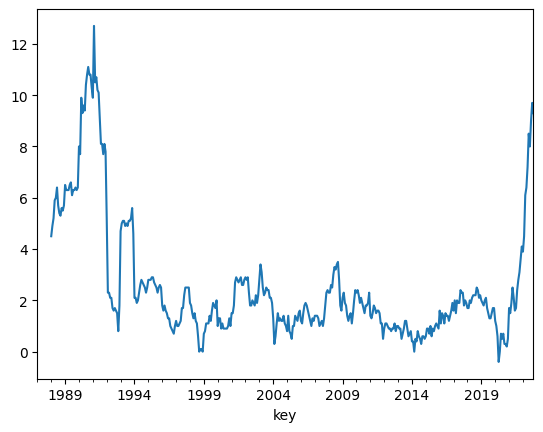

In [201]:
df.iloc[:,2].plot()

In [202]:
df.to_pickle("CPIF.pkl")

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 430 entries, 1987-01-01 to 2022-10-01
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CPIF, Index, 1987=100            430 non-null    float64
 1   CPIF, monthly changes, 1987=100  418 non-null    float64
 2   CPIF, annual changes, 1987=100   418 non-null    float64
dtypes: float64(3)
memory usage: 13.4 KB
